## Hoe voorspel je de groei van FlickBike ?
#### In het bijzonder: hoe voorspel je het aantal verhuurde fietsen op de dagen tussen 10 december 2019 en 31 januari 2020?

De groei van FlickBike is van veel factoren afhankelijk, zowel externe als interne factoren. Veel factoren zullen en/of kunnen niet meegenomen worden in het model omdat deze onberekenbaar, onbereikbaar of niet noemenswaardig zijn. Alle andere factoren die wel beschikbaar zijn moeten op correlatie onderzocht worden. Als bepaalde eigenschappen veel correlatie tonen met de target eigenschap, kunnen deze belangrijk zijn voor het model.

Dit probleem kan lastig opgelost worden met classificatie. Er zal dan hoogstwaarschijnlijk overfitting plaatsvinden ivm het hoge aantal target features.
Een van de modellen die gebruikt kan worden voor dit probleem is een decision tree regressor. 

## hoe kunnen bepaalde factoren invloed hebben of krijgen op het model?

#### Het weer

Voor het gebruiken van weer moeten eerst een aantal weer factoren gekozen worden. Intuitief zouden bijvoorbeeld de neerslag een invloed kunnen hebben op de verhuur van fietsen ivm het feit dat mensen niet van houden om nat te regenen. Maar dit blijft een aanname. Er zal eerst een correlatie moeten worden gezocht tussen weerfactoren en verandering in fiets verhuur / gebruik.

#### Dag van de week

De dag van de week kan ook zeer sterke correlatie hebben met het aantal gebruikte huurfietsen. Je zou zeggen dat doordeweeks meer fietsen gebruikt worden omdat veel mensen alleen doordeweeks werken. Door de dag van de week als integer (1-7) of als string (ma-su) kan een nieuwe kolom met data aan het verhuurbestand toegevoegd worden.

#### Bijzondere dagen

Bijzondere dagen kunnen als boolean waarde opgeslagen worden in de dataset. Om de data expansie zo gering mogelijk te houden kunnen bepaalde groepen van bijzondere dagen als gecombineerde waarde bij de dataset gevoegd worden. Dit voorkomt het plaatsen van boolean waardes voor elke bijzondere dag. De groepering kan door bijvoorbeeld een cluster algoritme gemaakt worden waarbij de groepen worden gemaakt op basis van overkeenkomsten in relatie tot de target feature(s)

#### Eventuele andere factoren

Eventuele factoren om mee te nemen zijn:
- concurrenten die de markt opeisen
- financiele of medische crisissen
- bedrijfs/personeels veranderingen/problemen

## Hoe kan voorspeld worden op welke plekken fietstekorten kunnen ontstaan

Het is lastig om te voorspellen wanneer er tekorten ontstaan. Je weet immers nooit of iemand ergens een fiets misloopt. Een soort van feedback systeem zou misschien inzicht geven in waar mensen vaak geen fiets kunnen vinden. Ook kan je niet zien hoelang iemand naar een fiets heeft gezocht of hoelang deze persoon ervoor heeft moeten lopen.

Wel kan gekeken worden naar plekken waar veel fietsen worden gebruikt. Met andere woorden, in welk gebied wordt het meest een fiets gepakt en waar wordt het meest gefietst. Door de kijken naar de fiets routes kan een schatting gemaakt waar fietsen hotspots liggen.

## Hoe bereken je het minimaal aantal fietsen dat nodig is?



## Correlatie weer en verhuur

In [91]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [92]:
df_bikes = pd.read_csv("bikes.csv") # https://canvas.hu.nl/files/850822/download?download_frd=1
df_bikes["date"] = pd.to_datetime(df_bikes["date"],format="%Y-%m-%d %H:%M:%S")
# print(df_bikes[["date"]].sort_values("date",ascending=True).head())
# print(df_bikes[["date"]].sort_values("date").tail())


In [93]:
df_weer = pd.read_csv("weer.csv")
df_weer["YYYYMMDD"] = pd.to_datetime(df_weer["YYYYMMDD"],format="%Y%m%d")
df_weer.head()

,STN,YYYYMMDD,FG,TG,SQ,RH
0,240,2019-01-01,76,77,13,5
1,240,2019-01-02,48,56,4,-1
2,240,2019-01-03,23,31,46,-1
3,240,2019-01-04,45,54,0,-1
4,240,2019-01-05,65,72,0,1


In [94]:
df_bikes_per_day = df_bikes[["bikenumber"]].groupby([df_bikes["date"].dt.date]).count()
df_bikes_per_day["day"] = pd.to_datetime(df_bikes_per_day.index,format="%Y-%m-%d %H:%M:%S")
df_bikes_per_day.rename(columns={"bikenumber":"amount_of_bikes"},inplace=True)

In [107]:
df_weer_verhuur = df_weer.merge(df_bikes_per_day,how='left', left_on='YYYYMMDD', right_on="day")
df_weer_verhuur.drop(["STN"],axis=1,inplace=True)

#### Windsnelheid

Text(0.5, 1.0, 'Relatie windsnelheid en verhuurde fietsen')

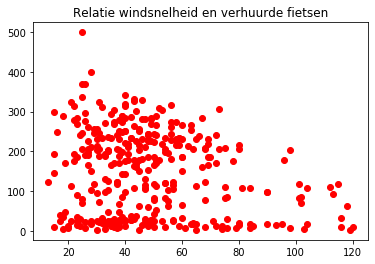

In [135]:
df_weer_verhuur.sort_values("FG",inplace=True)
plt.plot(df_weer_verhuur["FG"],df_weer_verhuur["amount_of_bikes"],'ro')
plt.title("Relatie windsnelheid en verhuurde fietsen")

#### Temperatuur

Text(0.5, 1.0, 'Relatie temperatuur en verhuurde fietsen')

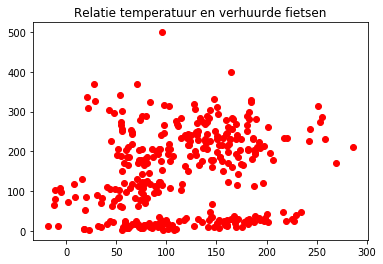

In [134]:
df_weer_verhuur.sort_values("TG",inplace=True)
plt.plot(df_weer_verhuur["TG"],df_weer_verhuur["amount_of_bikes"],'ro')
plt.title("Relatie temperatuur en verhuurde fietsen")

#### Zonnestraling

Text(0.5, 1.0, 'Relatie zonnestraling en verhuurde fietsen')

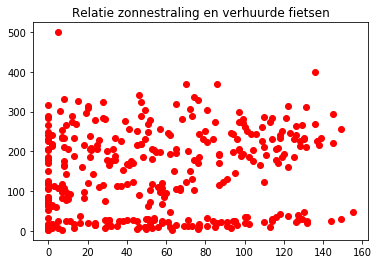

In [133]:
df_weer_verhuur.sort_values("SQ",inplace=True)
plt.plot(df_weer_verhuur["SQ"],df_weer_verhuur["amount_of_bikes"],'ro')
plt.title("Relatie zonnestraling en verhuurde fietsen")

#### Neerslag

Text(0.5, 1.0, 'Relatie neerslag en verhuurde fietsen')

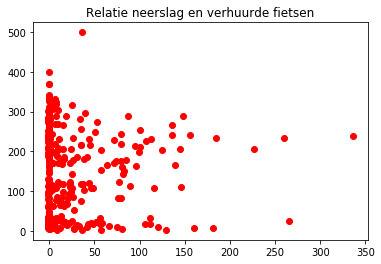

In [132]:
df_weer_verhuur.sort_values("RH",inplace=True)
plt.plot(df_weer_verhuur["RH"],df_weer_verhuur["amount_of_bikes"],'ro')
plt.title("Relatie neerslag en verhuurde fietsen")

In [112]:
df_weer_verhuur.corr()

,FG,TG,SQ,RH,amount_of_bikes
FG,1.000000,-0.059668,-0.279035,0.294033,-0.211923
TG,-0.059668,1.000000,0.455578,0.022139,0.180438
SQ,-0.279035,0.455578,1.000000,-0.343670,0.125715
RH,0.294033,0.022139,-0.343670,1.000000,-0.004523
amount_of_bikes,-0.211923,0.180438,0.125715,-0.004523,1.000000


<i>
    FG = windkracht
    TG = temperatuur
    SQ = zonnestraling
    RH = neerslag
</i>

Hieruit blijkt dat weer gegevens weinig invloed heeft op het aantal verhuurde fietsen. De grootste correlatie is te zien bij windkracht met een negatieve correlatie van 0.2. Zelfs daar is dus geen correlatie te vinden. Misschien valt er een betere correlatie te behalen door meerdere variabelen te combineren en een LR model op te stellen, maar veel verbetering wordt hier niet verwacht. 

Een mogelijke reden voor de slechte correlatie kan te maken hebben met waar deze fietsen voor bedoeld zijn, namelijk als vervoer van en naar het werk. Zoals al gezegd is heeft dit niets te maken met woon-werk verkeer en wordt de fiets regelmatig gepakt om bijvoorbeeld wat eten te halen, maar toch worden werknemers meer gedwongen de fiets te pakken dan wanneer iemand in zijn vrije tijd de fiets pakt.

Weer gegevens gaan we dus niet meenemen in de decision tree regressor. Mogelijk is er toch een verband te vinden door de data anders te transformeren of combineren, dus dit wordt de volgende stap.